In [1]:
import sys

sys.path.insert(0, "../..")

import torch
from scalarize.utils.contribution import (
    backward_greedy_values,
    forward_greedy_values,
    maximal_values,
    shapley_values,
)
from scalarize.utils.scalarization_functions import HypervolumeScalarization
from scalarize.utils.scalarization_objectives import flatten_scalarized_objective
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
def get_utility_values(Y, indices, scalarization_fn):
    num_params = len(indices)
    utility_values = torch.zeros(num_params)
    for i in range(num_params):
        Y_i = Y[indices[: i + 1]]
        value_i = scalarization_fn(Y_i).max(dim=0).values.mean()
        utility_values[i] = value_i
    return utility_values


def get_contribution_values(pf, scalarized_Y, rand_max=False):
    contribution_values = {}
    # shapley values
    shapley_vals = shapley_values(sY)
    vals, shapley_idx = shapley_vals.sort()
    shapley_pf = pf[shapley_idx.flip(dims=[0])]
    shapley_sfn = get_utility_values(pf, shapley_idx.flip(dims=[0]), scalarization_fn)
    contribution_values["Shapley"] = [
        shapley_vals,
        shapley_pf,
        shapley_sfn,
        "dodgerblue",
    ]

    # maximal values
    maximal_vals = maximal_values(sY)
    vals, maximal_idx = maximal_vals.sort()
    if rand_max:
        torch.manual_seed(0)
        maximal_idx = torch.randperm(maximal_idx.size(0))
    maximal_pf = pf[maximal_idx.flip(dims=[0])]
    maximal_sfn = get_utility_values(pf, maximal_idx.flip(dims=[0]), scalarization_fn)
    contribution_values["Maximal"] = [maximal_vals, maximal_pf, maximal_sfn, "crimson"]

    # forward greedy values
    forward_greedy_vals = forward_greedy_values(sY)
    vals, forward_greedy_idx = forward_greedy_vals.sort()
    forward_greedy_pf = pf[forward_greedy_idx.flip(dims=[0])]
    forward_greedy_sfn = get_utility_values(
        pf, forward_greedy_idx.flip(dims=[0]), scalarization_fn
    )
    contribution_values["Forward greedy"] = [
        forward_greedy_vals,
        forward_greedy_pf,
        forward_greedy_sfn,
        "mediumseagreen",
    ]

    # backward greedy values
    backward_greedy_vals = backward_greedy_values(sY)
    vals, backward_greedy_idx = backward_greedy_vals.sort()
    backward_greedy_pf = pf[backward_greedy_idx.flip(dims=[0])]
    backward_greedy_sfn = get_utility_values(
        pf, backward_greedy_idx.flip(dims=[0]), scalarization_fn
    )
    contribution_values["Backward greedy"] = [
        backward_greedy_vals,
        backward_greedy_pf,
        backward_greedy_sfn,
        "orange",
    ]

    return contribution_values

In [3]:
def plot_contribution_values(
    p, pareto_front, contribution_values, title, max_utility=1
):
    fig = plt.figure(figsize=(17, 3))
    plt.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.35
    )
    eps = 0.05
    ax = fig.add_subplot(1, 5, 1)
    ax.scatter(
        pf[:, 0],
        pf[:, 1],
        color="k",
        s=20,
        label=r"Objective vectors: $\mathbf{y} \in Y$",
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"$y^{(1)}$", fontsize=15)
    ax.set_ylabel(r"$y^{(2)}$", fontsize=15)
    ax.set_title("Pareto front", fontsize=20)
    j = 2
    for key, value in contribution_values.items():
        ax = fig.add_subplot(1, 5, j)
        ax.scatter(value[1][0:p, 0], value[1][0:p, 1], color=value[-1], s=20)
        ax.set_title(key, fontsize=20)
        ax.set_xlabel(r"$y^{(1)}$", fontsize=15)
        ax.set_ylabel(r"$y^{(2)}$", fontsize=15)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim([0 - eps, 1 + eps])
        ax.set_ylim([0 - eps, 1 + eps])
        j += 1

    return fig

In [4]:
num_params = 100000 - 2
num_outputs = 2
t_fn = UnitVector(num_outputs, transform_label="polar")
nadir = torch.zeros(num_outputs)
samples = torch.linspace(0.0001, 0.9999, num_params)
weights = t_fn.transform(samples.unsqueeze(-1))
scalarization_fn = HypervolumeScalarization(weights=weights, ref_points=nadir)

num_points = 50
t = torch.linspace(1, num_points, num_points)
p = 10

# Convex

In [5]:
samples = torch.linspace(0.001, 0.999, num_points)
pf = t_fn.transform(samples.unsqueeze(-1))
pf = torch.flip(pf, dims=(0,))

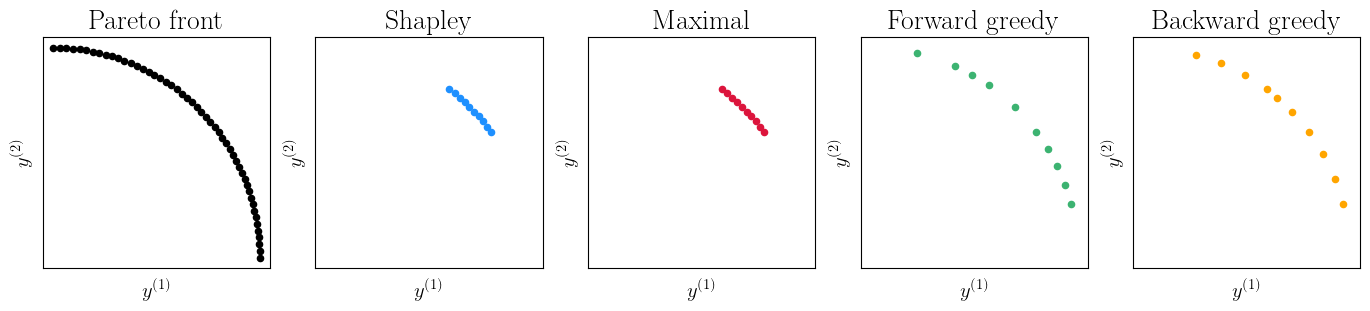

In [6]:
sY = flatten_scalarized_objective(pf.unsqueeze(-2), scalarization_fn)
c_values = get_contribution_values(pf, sY)
fig = plot_contribution_values(p, pf, c_values, title="Convex Pareto front")

# Concave

In [7]:
u = torch.linspace(0.001, 0.999, num_points)

x = -torch.cos(u * torch.pi / 2) + 1
y = -torch.sin(u * torch.pi / 2) + 1

pf = torch.column_stack([x, y])

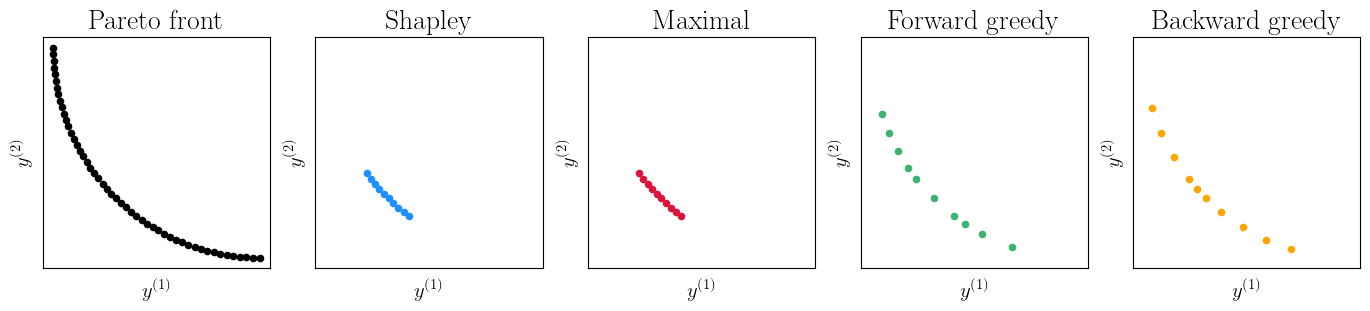

In [8]:
sY = flatten_scalarized_objective(pf.unsqueeze(-2), scalarization_fn)
c_values = get_contribution_values(pf, sY)
fig = plot_contribution_values(p, pf, c_values, title="Concave Pareto front")

# Disconnected

In [9]:
from botorch.test_functions.multi_objective import ZDT3
from botorch.utils.transforms import normalize

In [10]:
M = 2
problem = ZDT3(negate=True, dim=2)
pf = problem.gen_pareto_front(n=num_points)
bounds = torch.zeros(2, M)
bounds[0, 0] = min(pf[:, 0])
bounds[0, 1] = min(pf[:, 1])
bounds[1, 0] = max(pf[:, 0])
bounds[1, 1] = max(pf[:, 1])
pf = normalize(pf, bounds=bounds)
pf = torch.flip(pf, dims=(0,))

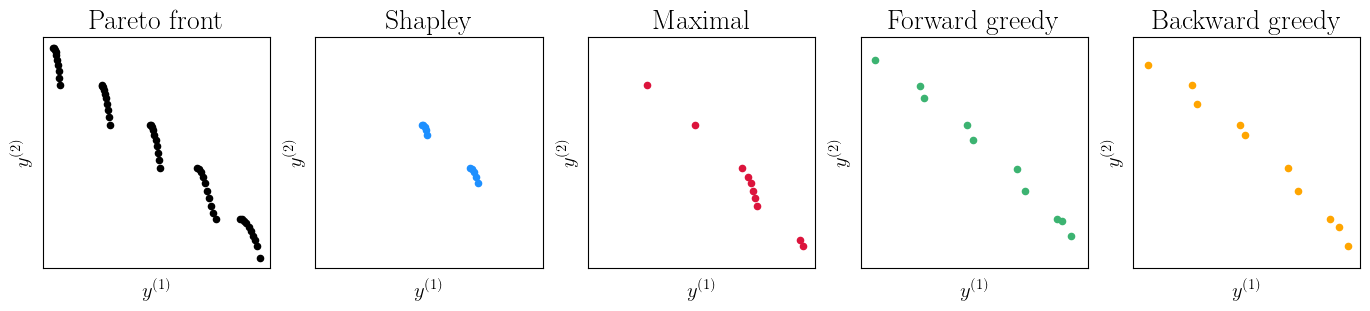

In [11]:
sY = flatten_scalarized_objective(pf.unsqueeze(-2), scalarization_fn)
c_values = get_contribution_values(pf, sY)
fig = plot_contribution_values(p, pf, c_values, title="Disconnected Pareto front")